In [1]:
# Set project root
import os
import sys

# Manually set the path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from src.data import load_measurements_from_yaml
from src.utils import load_calibration_json, load_rgb
from src.matching import (
    extract_features,
    match_descriptors,
    compute_homography,
    visualize_homography,
)

from src.geometry import (
    derive_metric_homography,
)

In [3]:
# Load measurement data
data = load_measurements_from_yaml("../assets/measurements.yaml")

# Load camera calibration
K, dist_coeffs, image_size = load_calibration_json("../assets/camera_calibration.json")

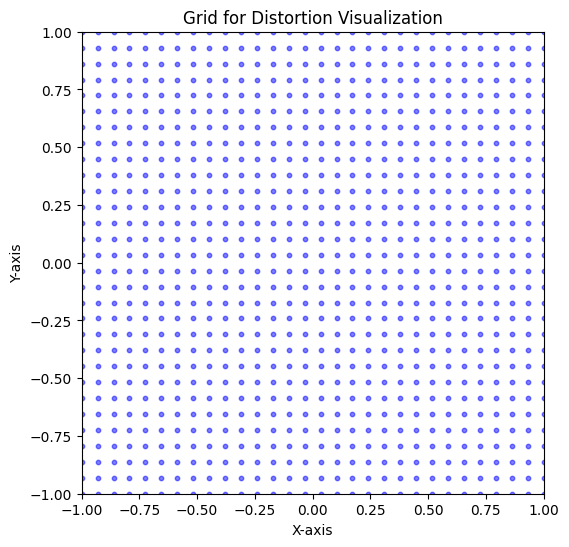

In [4]:
# Create a simple image with a grid of points, that will be used to visualize distortion

# Create a grid of points
x = np.linspace(-1, 1, 30)
y = np.linspace(-1, 1, 30)
X, Y = np.meshgrid(x, y)

# Plot the grid
plt.figure(figsize=(6, 6))
# Plot points as a scatter plot
plt.scatter(X, Y, color='blue', s=10, alpha=0.5)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title('Grid for Distortion Visualization')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [5]:
# Function for radial distortion
def radial_distortion(point, center, k1, k2):
    """Apply radial distortion to a point."""
    x, y = point
    cx, cy = center
    dx = x - cx
    dy = y - cy
    r2 = dx**2 + dy**2
    factor = 1 + k1 * r2 + k2 * r2**2
    return (cx + dx * factor, cy + dy * factor)

(-1.0, 1.0)

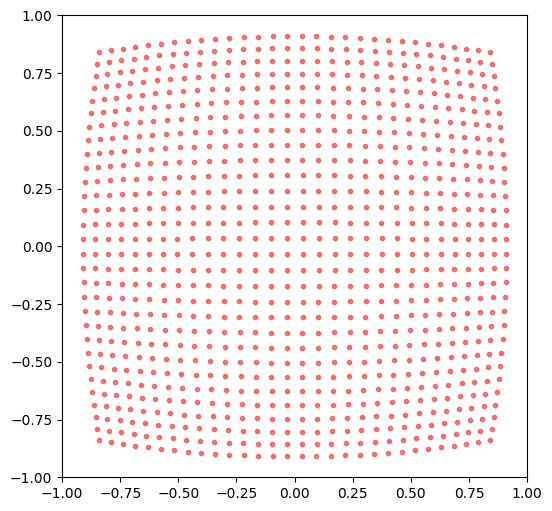

In [6]:
# Example usage of the radial distortion function
center = (0, 0)  # Center of distortion
k1 = -0.1  # Radial distortion coefficient
k2 = 0.01  # Higher-order radial distortion coefficient
distorted_points = [radial_distortion((x, y), center, k1, k2) for x, y in zip(X.flatten(), Y.flatten())]

# Plot the distorted grid
distorted_X, distorted_Y = zip(*distorted_points)
plt.figure(figsize=(6, 6))
plt.plot(distorted_X, distorted_Y, 'r.', alpha=0.5)
plt.xlim(-1, 1)
plt.ylim(-1, 1)

## Image distortion

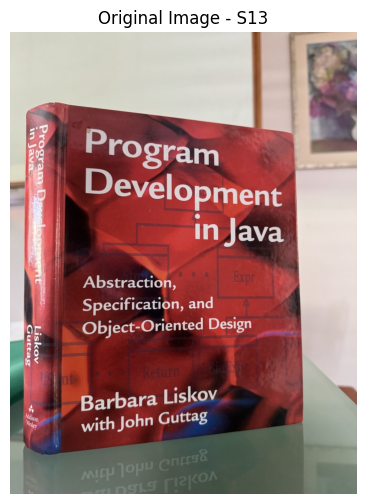

In [7]:
# Load an image
scene_id = "S13"
scene = data.get_scene(scene_id)
scene_path = os.path.join(project_root, scene.path)
scene_image = load_rgb(scene_path)

# Plot the original image
plt.figure(figsize=(8, 6))
plt.imshow(scene_image)
plt.title(f"Original Image - {scene_id}")
plt.axis('off')
plt.show()

In [8]:
def distort_image_inverse(image, k1, k2):
    """Apply radial distortion using inverse mapping."""
    h, w = image.shape[:2]
    center = (w / 2, h / 2)
    distorted_image = np.zeros_like(image)
    
    # Normalization factor
    norm_factor = max(w, h) / 2
    
    # Inverse mapping: for each output pixel, find where it comes from
    for y in range(h):
        for x in range(w):
            # Calculate normalized distance from center
            dx = (x - center[0]) / norm_factor
            dy = (y - center[1]) / norm_factor
            r_squared = dx*dx + dy*dy
            
            # Apply inverse distortion to find source coordinates
            distortion_factor = 1 + k1 * r_squared + k2 * r_squared * r_squared
            
            if distortion_factor <= 0:
                continue
            
            src_x = center[0] + (dx / distortion_factor) * norm_factor
            src_y = center[1] + (dy / distortion_factor) * norm_factor
            
            # Bilinear interpolation
            if 0 <= src_x < w-1 and 0 <= src_y < h-1:
                x1, y1 = int(src_x), int(src_y)
                x2, y2 = x1 + 1, y1 + 1
                
                fx = src_x - x1
                fy = src_y - y1
                
                # Interpolate
                top = image[y1, x1] * (1 - fx) + image[y1, x2] * fx
                bottom = image[y2, x1] * (1 - fx) + image[y2, x2] * fx
                distorted_image[y, x] = top * (1 - fy) + bottom * fy
    
    return distorted_image

def distort_image_inverse_vectorized(image, k1, k2):
    """Vectorized version for better performance."""
    h, w = image.shape[:2]
    center = np.array([w / 2, h / 2])
    
    # Normalization factor
    norm_factor = max(w, h) / 2
    
    # Create coordinate grids
    y_coords, x_coords = np.mgrid[0:h, 0:w]
    
    # Calculate normalized distances from center
    dx = (x_coords - center[0]) / norm_factor
    dy = (y_coords - center[1]) / norm_factor
    r_squared = dx*dx + dy*dy
    
    # Apply inverse distortion
    distortion_factor = 1 + k1 * r_squared + k2 * r_squared * r_squared
    
    # Avoid division by zero or negative factors
    valid_mask = distortion_factor > 0
    
    # Calculate source coordinates
    src_x = np.zeros_like(x_coords, dtype=np.float32)
    src_y = np.zeros_like(y_coords, dtype=np.float32)
    
    src_x[valid_mask] = center[0] + (dx[valid_mask] / distortion_factor[valid_mask]) * norm_factor
    src_y[valid_mask] = center[1] + (dy[valid_mask] / distortion_factor[valid_mask]) * norm_factor
    
    # Use OpenCV's remap for efficient interpolation
    distorted_image = cv2.remap(image, src_x, src_y, cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    
    return distorted_image

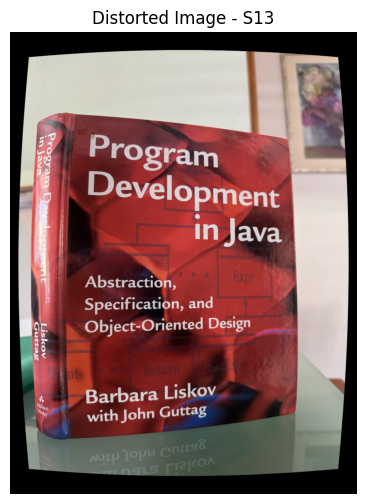

In [9]:
# Apply pincushion distortion to the image
k1 = -0.1  # Pincushion distortion coefficient
k2 = 0.01  # Higher-order radial distortion coefficient

distorted_image = distort_image_inverse_vectorized(scene_image, k1, k2)

# Plot the distorted image
plt.figure(figsize=(8, 6))
plt.imshow(distorted_image)
plt.title(f"Distorted Image - {scene_id}")
plt.axis('off')
plt.show()

In [10]:
def template_match(
    template_path: str,
    scene: np.ndarray,
    extract_method: str = "SIFT",
    match_method: str = "BF",
    plot: bool = True,
) -> tuple[np.ndarray | None, np.ndarray | None, tuple[int, int], float]:
    # Load template and scene images as RGB arrays
    template = load_rgb(template_path)

    # Extract features from both images using specified method
    template_keypoints, template_descriptors = extract_features(
        template, method=extract_method
    )
    scene_keypoints, scene_descriptors = extract_features(scene, method=extract_method)

    # Handle case where feature extraction failed
    if template_descriptors is None or scene_descriptors is None:
        return None, None, template.shape[:2], float("inf")

    # Match descriptors between template and scene
    matches = match_descriptors(
        template_descriptors, scene_descriptors, method=match_method
    )

    # Compute homography from matched keypoints
    homography, inlier_mask, reprojection_error = compute_homography(
        template_keypoints, scene_keypoints, matches
    )

    # Optional visualization of the matching result
    if plot and homography is not None:
        visualize_homography(
            template, scene, homography, title="Template Matching Result"
        )

    # Return results including template dimensions for reference
    return homography, inlier_mask, template.shape[:2], reprojection_error

In [11]:
def compute_homographies(scene_id, scenes, img):
    """
    This function analyzes a scene by executing the following steps:

    1. Load the scene and the corresponding templates.
    2. For each template, perform template matching against the scene image.
    3. Compute the homography.
    """
    # Load templates
    templates = [data.get_template(t_id) for t_id in scenes[scene_id]]

    # Iterate over templates
    results = {}
    for template in templates:
        template_path = os.path.join(project_root, template.path)

        # Compute pixel-pixel homography
        H, mask, t_shape, reprojection_error = template_match(template_path, img, extract_method='SIFT', match_method='BF', plot=True)

        template_size_px = plt.imread(template_path).shape[:2]

        # Derive the metric-pixel homography
        H_metric = derive_metric_homography(
            H_px=H,
            template_size_px=template_size_px,
            template_size_metric=(template.height, template.width)
        )

        results[template.id] = {
            'H_px': H.tolist(),
            'H_metric': H_metric.tolist()
        }

    return results

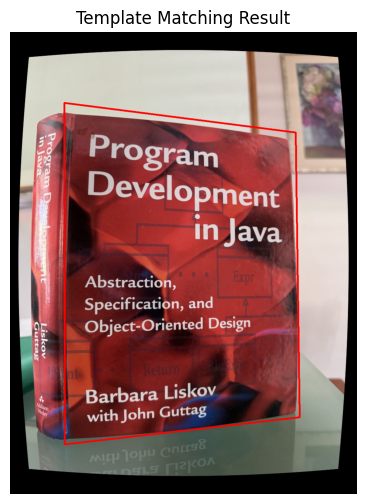

In [12]:
results = compute_homographies(scene_id, data.get_all_scenes(), img=distorted_image)

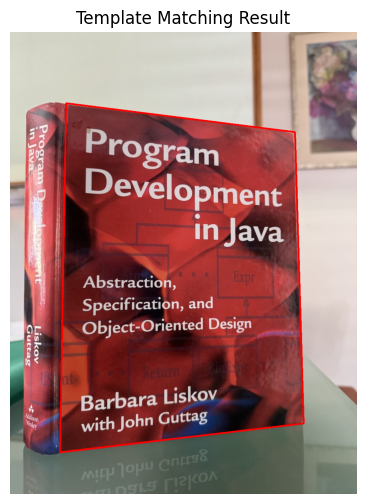

In [13]:
results_original = compute_homographies(scene_id, data.get_all_scenes(), img=scene_image)

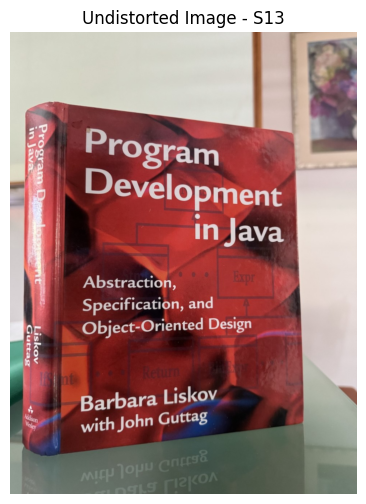

In [14]:
# Undistort the image using the known radial distortion coefficients
undistorted_image = distort_image_inverse_vectorized(distorted_image, -k1, -k2)

# Plot the undistorted image
plt.figure(figsize=(8, 6))
plt.imshow(undistorted_image)
plt.title(f"Undistorted Image - {scene_id}")
plt.axis('off')
plt.show()

In [15]:
H_metric = results["T2"]['H_metric']

# Get the corners of the template in world coordinates
w, h = data.get_template("T2").width, data.get_template("T2").height
corners_world = np.array([
    [0, 0],
    [w, 0],
    [w, h],
    [0, h],
])
# Apply the homography to the corners
corners_image = cv2.perspectiveTransform(corners_world.reshape(-1, 1, 2), np.array(H_metric).reshape(3, 3)).reshape(-1, 2)
corners_image.shape

(4, 2)

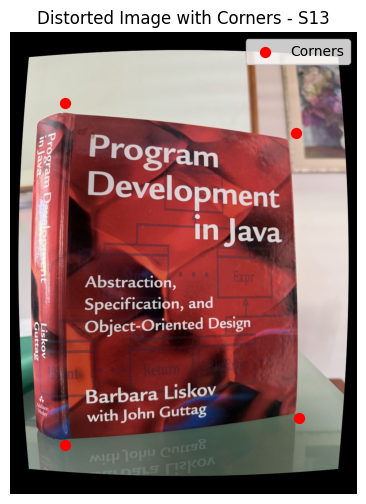

In [16]:
# Plot the image with the corners
plt.figure(figsize=(8, 6))
plt.imshow(distorted_image)
plt.title(f"Distorted Image with Corners - {scene_id}")
plt.axis('off')
plt.scatter(corners_image[:, 0], corners_image[:, 1], color='red', s=50, label='Corners')
plt.legend()
plt.show()

### Use calibrateCamera()

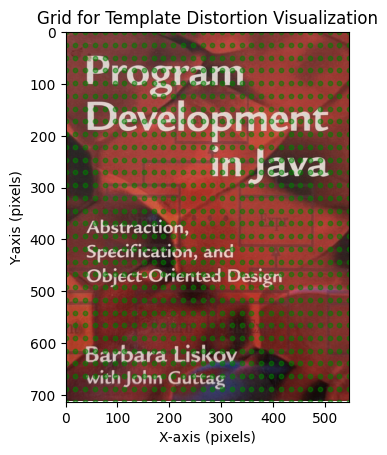

In [17]:
template = data.get_template("T2")
template_image = load_rgb(os.path.join(project_root, template.path))

w, h = template.width, template.height

# Find aspect ratio of the template (metric unit to pixel)
w_ar = template_image.shape[1] / w
h_ar = template_image.shape[0] / h

# Define a grid of points in the template's coordinate system
x = np.linspace(0, w, 30)
y = np.linspace(0, h, 30)
X, Y = np.meshgrid(x, y)

# Define the grid points in pixel coordinates
X_px = X * w_ar
Y_px = Y * h_ar

# Plot the grid
plt.imshow(template_image)
plt.scatter(X_px, Y_px, color='green', s=10, alpha=0.5)
plt.xlim(0, template_image.shape[1])
plt.ylim(template_image.shape[0], 0)
plt.title('Grid for Template Distortion Visualization')
plt.xlabel('X-axis (pixels)')
plt.ylabel('Y-axis (pixels)')
plt.show()

In [18]:
H = results_original["T2"]["H_metric"]

# Create 3D object points
object_points_3d = np.array([
    [x, y, 0.0] for x, y in zip(X.flatten(), Y.flatten())
], dtype=np.float32)
print(f"Object points 3D shape: {object_points_3d.shape}")

# Check object points
object_points_2d = np.array([
    [x, y] for x, y in zip(X.flatten(), Y.flatten())
], dtype=np.float32)
print(f"Object points 2D shape: {object_points_2d.shape}")

# Check homography transformation
image_points_2d = cv2.perspectiveTransform(
    object_points_2d.reshape(-1, 1, 2),
    np.array(H, dtype=np.float64)
).reshape(-1, 2)
print(f"Image points 2D shape: {image_points_2d.shape}")

Object points 3D shape: (900, 3)
Object points 2D shape: (900, 2)
Image points 2D shape: (900, 2)


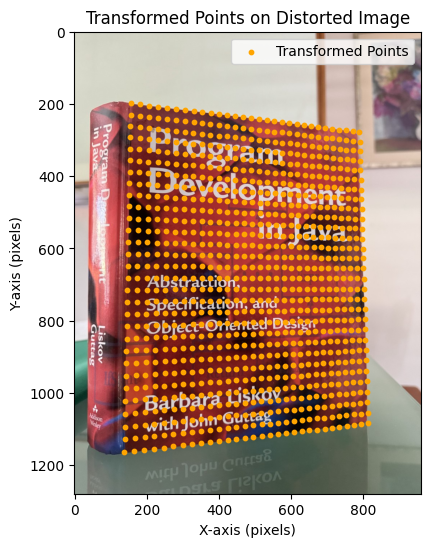

In [19]:
# Plot the transformed points
plt.figure(figsize=(8, 6))
# plt.imshow(distorted_image)
plt.imshow(scene_image)
plt.scatter(image_points_2d[:, 0], image_points_2d[:, 1], color='orange', s=10, label='Transformed Points')
plt.title('Transformed Points on Distorted Image')
plt.xlabel('X-axis (pixels)')
plt.ylabel('Y-axis (pixels)')
plt.legend()
plt.show()

In [20]:
# Prepare data for calibrateCamera (it expects lists of arrays)
object_points = [object_points_3d]
image_points = [image_points_2d]

# Image size for OpenCV (width, height)
image_size = (scene_image.shape[1], scene_image.shape[0])

# Initial estimate of camera matrix K
f = 877
u0, v0 = image_size[0] / 2, image_size[1] / 2
K_initial = np.array([
    [f, 0, u0],
    [0, f, v0],
    [0, 0, 1]
], dtype=np.float32)

# Initial estimate of distortion coefficients
dist_coeffs_initial = np.zeros(5, dtype=np.float32)  # k1, k2, p1, p2, k3

flags = (
    cv2.CALIB_USE_INTRINSIC_GUESS |
    cv2.CALIB_FIX_PRINCIPAL_POINT |
    cv2.CALIB_FIX_ASPECT_RATIO |
    cv2.CALIB_ZERO_TANGENT_DIST |
    cv2.CALIB_FIX_K3 |
    cv2.CALIB_FIX_K4 |
    cv2.CALIB_FIX_K5 |
    cv2.CALIB_FIX_K6
)

ret, K_refined, dist_coeffs, r_vecs, t_vecs = cv2.calibrateCamera(
    objectPoints=object_points,
    imagePoints=image_points,
    imageSize=image_size,
    cameraMatrix=K_initial,
    distCoeffs=dist_coeffs_initial,
    flags=flags
)

# Print the refined camera matrix and distortion coefficients
print("Refined Camera Matrix (K):")
print(K_refined)
print("\nRefined Distortion Coefficients:")
print(dist_coeffs)

print(f"\nReal, k1: {k1}, k2: {k2}")

Refined Camera Matrix (K):
[[943.27711266   0.         480.        ]
 [  0.         943.27711266 640.        ]
 [  0.           0.           1.        ]]

Refined Distortion Coefficients:
[[ 0.00157202]
 [-0.01773571]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]

Real, k1: -0.1, k2: 0.01


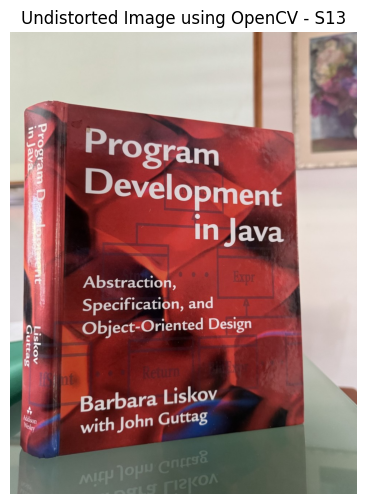

In [21]:
# Try and undistort the image using the refined parameters
undistorted_cv2 = distort_image_inverse_vectorized(scene_image, -dist_coeffs[0], -dist_coeffs[1])

# Plot the undistorted image using OpenCV
plt.figure(figsize=(8, 6))
plt.imshow(undistorted_cv2)
plt.title(f"Undistorted Image using OpenCV - {scene_id}")
plt.axis('off')
plt.show()

In [22]:
# Compute absolute and percentage errors on k1 and k2
k1_error = abs(k1 - dist_coeffs[0])
k2_error = abs(k2 - dist_coeffs[1])
k1_percentage_error = (k1_error / abs(k1)) * 100 if k1 != 0 else 0
k2_percentage_error = (k2_error / abs(k2)) * 100 if k2 != 0 else 0

print(f"Absolute error in k1: {k1_error}, Percentage error: {k1_percentage_error}%")
print(f"Absolute error in k2: {k2_error}, Percentage error: {k2_percentage_error}%")

Absolute error in k1: [0.10157202], Percentage error: [101.57201941]%
Absolute error in k2: [0.02773571], Percentage error: [277.35714944]%
